In [1]:
import librosa 
import librosa.display 
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr
from tensorflow.keras.models import load_model # type: ignore
import pickle

c:\Users\panya\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def spectrogram_cal(data,fs):
    ms = librosa.feature.melspectrogram(y=data, sr=fs, n_fft=2048, hop_length=128, n_mels=256)
    spectrogram_db = librosa.power_to_db(ms, ref=np.max)
    
    return spectrogram_db

In [3]:
from scipy.fft import fft, fftfreq

def audioFFT_cal (data,fs,t):
    N = int(fs * t)         # Number of sample points
    T = 1.0 / (fs)          # sample spacing
    yf = fft(data)
    Xf = fftfreq(N, T)[:N//2]
    FFT_Amplitude = 10*np.log(np.abs(yf[0:N//2]))
    
    return Xf,FFT_Amplitude

# Load CNN model and label config

In [4]:
# Load CNN Model
print('-----------------------------------------')
print("#: load CNN model")
myModel = load_model('./model\model_01\myModel.h5') 
myModel.summary()


-----------------------------------------
#: load CNN model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 170, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 85, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 83, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 41, 128)       0         
_________________________________________________________________
dense (Dense)                (None, 62, 41, 64)        8256      
_________________________________________________________________
dense_1 (Dense)              (None, 62, 41, 32)        2080      
______________________________________________________________

In [ ]:
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore

# load config
print('-----------------------------------------')
print("#: load label config")

with open ('./DataSetForTrain/labels', 'rb') as fp:
    labels = pickle.load(fp)

print("labels : " + str(labels))
# Encode target labels
label_encoder = LabelEncoder()
label_encoder.fit_transform(labels)

-----------------------------------------
#: load label config
labels : ['Drone', 'No_Drone']


array([0, 1], dtype=int64)

In [6]:
# Load the Drone audio file
print('-----------------------------------------')
print("#: Load the Drone audio file")
audio_file = 'D:\\DroneDetection\\AudioCapture\\DroneTest\\audiotest.wav'  # Replace with your audio file path
audio_signal, fs = librosa.load(audio_file) 

audio_signal = audio_signal[:22000]
timesDuration = librosa.get_duration(y=audio_signal, sr=fs)

# normalize audio  
max_value = np.max(np.abs(audio_signal))       # Determine the maximum values
audio_Drone = audio_signal/max_value           # Use max_value and normalize sound data to get values between -1 & +1

stationary=True
prop_decrease=1
n_std_thresh_stationary = 1

# perform noise reduction
audio_reduced_noise = nr.reduce_noise(y=audio_signal, 
                                sr=fs, 
                                stationary=stationary, 
                                prop_decrease=prop_decrease,
                                n_std_thresh_stationary=n_std_thresh_stationary)    # ,use_torch=True )

spectrogram_input = spectrogram_cal(audio_reduced_noise,fs)
print('Done !!')
print()

print(f'Sampling Rate: {fs} Hz')
print(f'Audio Duration: {timesDuration:.0f} seconds')

-----------------------------------------
#: Load the Drone audio file
Done !!

Sampling Rate: 22050 Hz
Audio Duration: 1 seconds


In [7]:
from IPython.display import Audio  # type: ignore

Audio(data=audio_signal, rate=fs)

In [8]:
# Apply Model 
print('-----------------------------------------')
print("#: Predict Output")
print('- Prepare testing input data')
X = np.array(spectrogram_input)
X = X.reshape(X.shape[0], X.shape[1], 1)
xtest = X / 255.0

print("xtest shape : " + str(xtest.shape))

Ytest = xtest

Ytest = Ytest.reshape(1, Ytest.shape[0], Ytest.shape[1], 1)
y_predicted = myModel.predict(Ytest)
output =  y_predicted.argmax(axis=1)
lable_Output = label_encoder.inverse_transform(output)

print()
print(f'Predicted Output : {y_predicted}')
print(f'Output Index : {output}')
print(f'Output Lable : {lable_Output}')

-----------------------------------------
#: Predict Output
- Prepare testing input data
xtest shape : (256, 172, 1)

Predicted Output : [[1.5334732e-06 9.9999845e-01]]
Output Index : [1]
Output Lable : ['No_Drone']


#: Convert audio to spectrogram and using noise reduce process


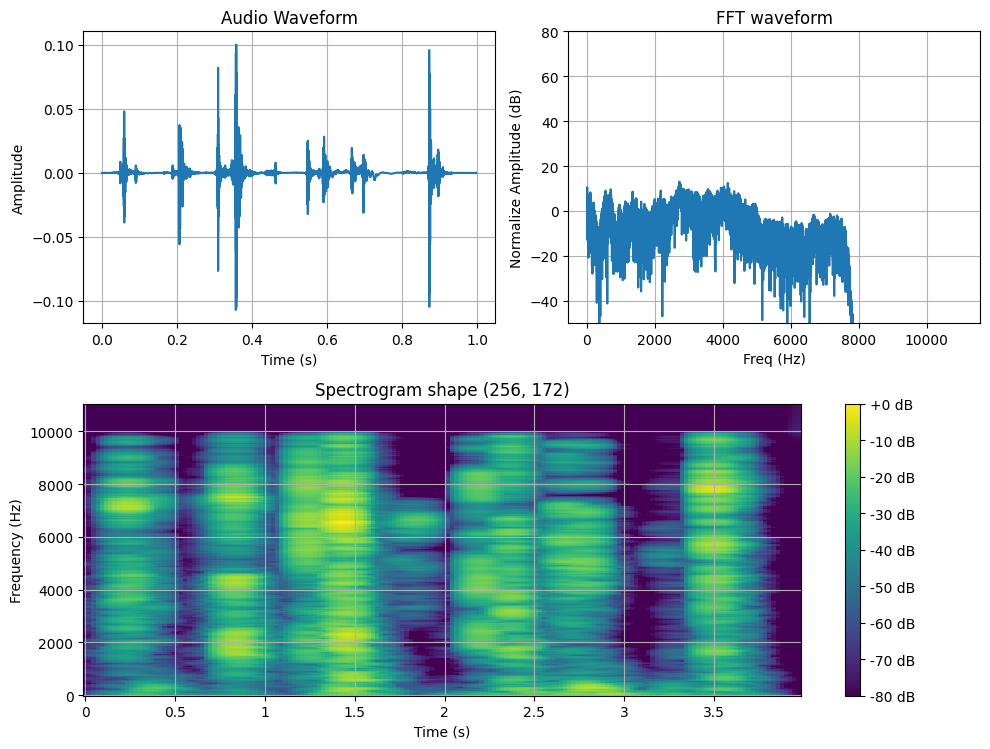

In [9]:
print("#: Convert audio to spectrogram and using noise reduce process")

plt.figure(figsize=(10, 8))
# ----- Plot Audio Waveform  -----
plt.subplot(2, 2, 1)
plt.title(f'Audio Waveform')
plt.plot(np.linspace(0, len(audio_reduced_noise) / fs, len(audio_reduced_noise)), audio_reduced_noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
# ----- Plot FFT  -----
xf,yf = audioFFT_cal(audio_reduced_noise,fs,timesDuration)    
plt.subplot(2, 2, 2)
plt.title(f'FFT waveform')
plt.plot(xf, yf)
plt.grid()
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalize Amplitude (dB)')
plt.ylim(-50,80)

# ------- Plot Spectrogram ---------
spectrogram_db = spectrogram_cal(audio_reduced_noise,fs)
plt.subplot(2, 1, 2)
plt.title(f'Spectrogram')
librosa.display.specshow(spectrogram_db, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
#cmap = 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram shape {spectrogram_db.shape}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()